# Fisher Vector
    - into a fix-sized vector
    - by gradient of the log-likelihood fuction w.r.t a set of parameter vectors(해당 가우시안 가중치, 평균, 분산)
        - 얼마나 loca feature의 분포를 설명하는데 k개 각각 가우시안 분포가 영향을 미치는지 정도에 따라, 각각 파라미터에 대한 편미분에 대한 병합 벡터로서 quantization!
   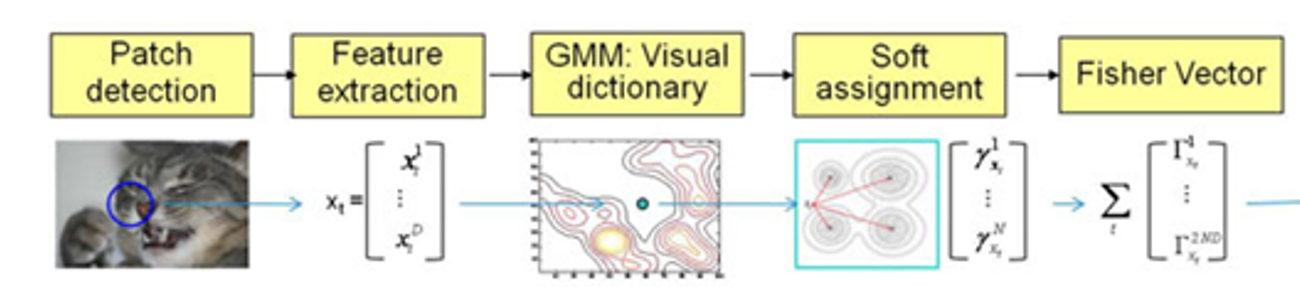
   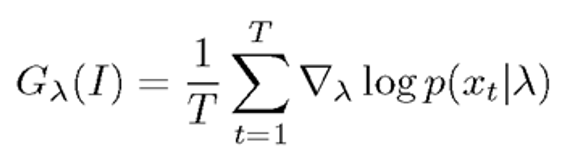

## 원리
    - feature들을 K개의 가우시안 분포에 대한 확률로 표현 - Soft Quatization
        - 더 정확한 표현
        - 같은 정확도 대비 더 적은 K(cluster, gaussian 분포의 개수) : 분포 당 1개의 평균, 분산 
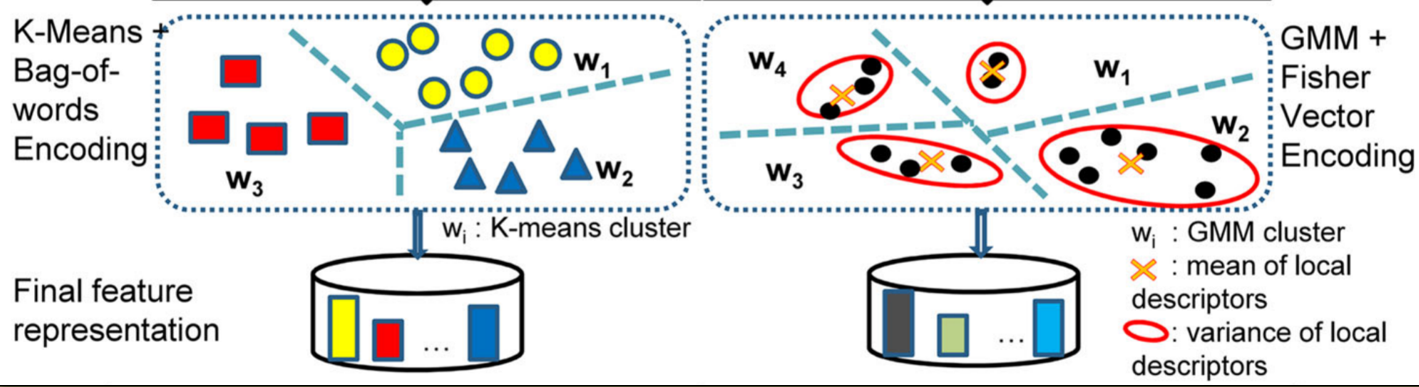

In [1]:
!pip3 install fishervector

  Created wheel for fishervector: filename=fishervector-0.1-py3-none-any.whl size=3686 sha256=7e396ba2d72879c7fed890c50ce4ed0ea7b8e852338684c0a100d8db49e1b97c
  Stored in directory: /root/.cache/pip/wheels/81/66/58/f5f7a3ab4198f2e899f7cfadffef8bc51af15a3bcd2f9a08d8
Successfully built fishervector


In [3]:
from fishervector import FisherVectorGMM
import numpy as np
from pathlib import Path
import glob
import os
import cv2
import time
import pandas as pd
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

In [4]:
def sift_extractor(file_path):
    '''
    Description: extract \emph{sift} feature from given image
    Input: file_path - image path
    Output: des - a list of descriptors of all the keypoint from the image
    '''
    img = cv2.imread(file_path)
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create() #query에 대해서는 full! #아 이것도 전체를 다 뽑은 것이 아니구나!
    _,des = sift.detectAndCompute(gray,None) 

    return des

# 0. Setup
    - file_list
    - load DB SIFT feat_Set

In [5]:
#path
test_q_path = '/home/Signboard_Retrieval/roadview_384_crop/test/q_for_test/*.png'
test_db_path = '/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/*'

# root
test_q_root = str(Path(test_q_path).parent) + '/'
test_db_root = str(Path(test_db_path).parent) + '/'
# name_sorted_list
test_q_name_sorted = sorted([Path(q_path).stem for q_path in glob.glob(test_q_path)])
test_db_name_sorted = sorted([Path(db_path).stem for db_path in glob.glob(test_db_path)])
# path_list
test_q_path_sorted = sorted([q_path for q_path in glob.glob(test_q_path)])
test_db_path_sorted = sorted([db_path for db_path in glob.glob(test_db_path)])

In [6]:
len(test_db_path_sorted)

3377

In [2]:
# load DB descriptors

filename = "/home/Signboard_Retrieval/roadview_384_crop/test/checkpoint/feat_set/" + "test_db_200" + ".npy"
db_feat_set = np.load(filename).astype(np.float32)

In [3]:
db_feat_set.shape

(667943, 128)

### Test
    - db : 100개
    - k = 3

In [ ]:
# test

filename = "/home/Signboard_Retrieval/roadview_384_crop/test/checkpoint/feat_set/" + "test_db_featureset_100" + ".npy" #bow든 vlad 든 3377개에 대한 sift local feature set으로 동일하다!
test_feat_set = np.load(filename)

In [7]:
# 직접 개수를 설정하기
fv_gmm = FisherVectorGMM(n_kernels=3).fit(test_feat_set[np.newaxis, :])

fitted GMM with 3 kernels


In [13]:
des1 = sift_extractor(test_q_path_sorted[0])
des2 = sift_extractor(test_q_path_sorted[1])
print(des1.shape, des2.shape)
fv1 = fv_gmm.predict(des1[np.newaxis,:])
fv2 = fv_gmm.predict(des2[np.newaxis,:])
print(fv1.shape, fv2.shape) #FV의 차원 되짚기: (1+2D)*K = (1*K) + (2K*D) --> (2*3=6, D=128)


(422, 128) (1000, 128)
(1, 6, 128) (1, 6, 128)


# 1. Train K GMM for fv
    - Experimental : try&error
    - By Standard of Info : AIC(아카이케 정보 기준), BIC(베이즈 정보 기준)
        : 최적 음의 가능도에 모델의 개수(복잡도)로 벌점을 취하는 방식
        1. AIC : 과적합되는 모델의 개수를 선택하는 경향(즉, 더 많은 K값을 선택)
        2. BIC : 과소적합 --> 더 엄격한 기준(즉, 더 적은 K값 선택 경향)

In [17]:
# k개 gaussian kerenl
# k_list = [700, 800, 900]
k = 300 #-> 300
D = 128 # SIFT : 8(bin) * 4^2(patch) 
                #num_ang_bins (int, optional) – Number of angular bins. Default: 8
                #num_spatial_bins (int, optional) – Number of spatial bins. Default: 4

In [5]:
# Train GMM for representing fisher vector

#time check - Time of learning codebook(Off_line)
cb_t_b = time.perf_counter()

for k in k_list:

    # # 직접 개수를 설정하기
    fv_gmm = FisherVectorGMM(n_kernels=k).fit(db_feat_set[np.newaxis, :])
    
    with open("/home/Signboard_Retrieval/roadview_384_crop/test/checkpoint/" + f"fv_gmm_{k}_200" + ".p", 'wb') as fp:
        pickle.dump(fv_gmm, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    # 적합한 가우스 분포의 개수 K를 찾기 위해 -> 정보 기준 AIC, BIC 비교.
    # fv_gmm = FisherVectorGMM().fit_by_bic(db_feat_set[np.newaxis, :], choices_n_kernels=[200,400, 600, 800,1000,2000,3000,5000]) # input Dim 4 or 3 ? (num of videos, num of images, ...) : 그냥 1 추가
    # fv_gmm = FisherVectorGMM().fit_by_bic(db_feat_set[np.newaxis, :]) #default = [5, 20, 60, 100, 200, 500]

# Time of learning codebook
cb_t = time.perf_counter() - cb_t_b

print(f"Time of Learning Codebook(Off_line):{cb_t}")

fitted GMM with 700 kernels
fitted GMM with 800 kernels
fitted GMM with 900 kernels
Time of Learning Codebook(Off_line):23224.864803257


## - save fv_gmm -> pickle

In [ ]:
# save from pickle

with open("/home/Signboard_Retrieval/roadview_384_crop/test/checkpoint/" + "fv_gmm_500_1000" + ".p", 'wb') as fp:
    pickle.dump(fv_gmm, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
# load from pickle
with open("/home/Signboard_Retrieval/roadview_384_crop/test/checkpoint/" + "fv_gmm_300_200" + ".p", 'rb') as fp:
    fv_gmm = pickle.load(fp)

In [19]:
fv_gmm

In [20]:
import faiss

#### total
# q_crop_path = '/home/Signboard_Retrieval/roadview_384_crop/q_crop/*.png'
# db_crop_path = '/home/Signboard_Retrieval/roadview_384_crop/db_crop/*.png'

#### test
#path
test_q_path = '/home/Signboard_Retrieval/roadview_384_crop/test/q_for_test/*.png'
test_db_path = '/home/Signboard_Retrieval/roadview_384_crop/test/db_for_test/*.png'

#### aug
#path
# test_q_path = '/home/Signboard_Retrieval/roadview_384_crop/test/aug_test/*.jpg'
# test_db_path = '/home/Signboard_Retrieval/roadview_384_crop/test/aug_test/*.jpg'

# name_list : test_q_name_sorted, test_db_name_sorted 

def quatization():
    
    # # root path
    # q_root_path = str(Path(test_q_path).parent) + '/'
    # db_root_path = str(Path(test_db_path).parent) + '/'
    
    ######DB Quantization
    
    # list
    db_fv_set = np.float32([]).reshape(0,2*D*k) #fv_dim : 2d*k
    
    for idx, db_path in enumerate(test_db_path_sorted): #name --> path
        
        try:
            # calculate sift feat.
            des = sift_extractor(db_path)

            # quantize fisher vector by fv_GMM
            db_fv = fv_gmm.predict(des[np.newaxis,:])
            db_fv = db_fv.reshape(1, -1) # (1, 2*K*D)
            db_fv_set = np.append(db_fv_set, db_fv, axis=0) #1차원 배열의 결합
        
        except: #SIFT kp가 없는 경우
            print(db_path)
            print("extract_feature_error")
    
    #Reshape
    db_fv_set = np.array(db_fv_set).reshape(len(db_fv_set), -1) #(개수, 차원_2*K*D)
    
    ######Query featVec_Set
    q_fv_set = np.float32([]).reshape(0,2*D*k) #fv_dim : 2d*k
    
    for idx, q_path in enumerate(test_q_path_sorted): #name --> path
        
        try:
            # calculate sift feat.
            des = sift_extractor(q_path)
            # quantize fisher vector by fv_GMM
            q_fv = fv_gmm.predict(des[np.newaxis,:])
            q_fv = q_fv.reshape(1, -1) # (1, 2*K*D)
            q_fv_set = np.append(q_fv_set, q_fv, axis=0) #1차원 배열의 결합
        
        except: #SIFT kp가 없는 경우
            print(db_path)
            print("extract_feature_error")

    #Reshape
    q_fv_set = np.array(q_fv_set).reshape(len(q_fv_set), -1) #(개수, 차원_2*K*D)
    
    return db_fv_set, q_fv_set


def retrieval_faiss(db_featVec_set, q_featVec_set):
    
    ######make_db
    #make db (or with custom index)
    test_index = faiss.IndexFlatL2(db_featVec_set.shape[1]) # 2*K*D 차원으로 l2 dist 유사도 구한다!!
#     index = faiss.IndexIDMap2(index)
#     index.add_with_ids(db_featVec_set, db_ids)
    #test
    test_index.add(np.array(db_featVec_set.astype(np.float32)))
    
    #Check db
    print(f"check db num: {test_index.ntotal}-{len(test_db_name_sorted)}") ### ex) 개수 확인 - 1352 개의 DB가 모두 잘 들어갔구나!

    ######retrieval
    #faiss - retrieval
    distances, indices = test_index.search(q_featVec_set.astype(np.float32), test_index.ntotal) #(query feature set, k) -> topk
   
    #make dict
    match_dic = {}
    
    # query 1개의 topk개의 db images
    for idx, _ in enumerate(test_q_path_sorted):
        
        match_dic[idx] = (distances[idx], indices[idx]) #(distance_list of query, index_list of query)
    
    return match_dic

In [ ]:
#check time
ret_t_b = time.perf_counter()

####Retrieval
db_fv_set, q_fv_set = quatization()
match_dic = retrieval_faiss(db_fv_set, q_fv_set)

#time
ret_time = time.perf_counter() - ret_t_b
ret_time_per_img = ret_time / len(test_q_name_sorted)
print(f"ret_total_time:{ret_time}")
print(f"ret_time_per_img:{ret_time_per_img}")

/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/간판_가로형간판_030140_0.jpg
extract_feature_error
/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/간판_가로형간판_030192_0.jpg
extract_feature_error
/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/간판_가로형간판_030312_0.jpg
extract_feature_error
/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/간판_가로형간판_030431_0.jpg
extract_feature_error
/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/간판_가로형간판_030434_0.jpg
extract_feature_error
/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/간판_가로형간판_030555_0.jpg
extract_feature_error
/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/간판_가로형간판_030568_0.jpg
extract_feature_error
/home/Signboard_Retrieval/roadview_384_crop/test/db_distractor/간판_가로형간판_030632_0.jpg
extract_feature_error


In [12]:
q_fv_set.shape, db_fv_set.astype(np.float32).dtype

((100, 51200), dtype('float32'))

### Ret_Time_Board

In [ ]:
### Ret time

# 1. 9920 features (sift < 100)

#### k=10
# ret_total_time:2.813957948703319
# ret_time_per_img:0.002203569262884353

#### k=20
# ret_total_time:2.8379968479275703
# ret_time_per_img:0.0022223937728485283

#### k=30
# ret_total_time:2.8667708169668913
# ret_time_per_img:0.00224492624664596

#### k=50
# ret_total_time:2.905719444155693
# ret_time_per_img:0.0022754263462456486

#### k=100
# ret_total_time:3.0259807291440666
# ret_time_per_img:0.0023696011974503263

#### k=125
# ret_total_time:3.094700240995735
# ret_time_per_img:0.0024234144408737156

#### k=150
# ret_total_time:3.170893974136561
# ret_time_per_img:0.002483080637538419

# ----------------------------------    
    
# 1. 17993 features (sift < 200)

#### k=30
# ret_total_time:3.2064796071499586
# ret_time_per_img:0.002510947225646013

#### k=50
# ret_total_time:3.32543751783669
# ret_time_per_img:0.002604101423521292

#### k=60
# ret_total_time:3.3271755231544375
# ret_time_per_img:0.0026054624300347984

#### k=70
# ret_total_time:3.394462930969894
# ret_time_per_img:0.0026581542137587267

#### k=100
# ret_total_time:3.5248016701079905
# ret_time_per_img:0.002760220571736876

# ---------------------------------

# 2. 23512 features (sift < 300)

#### k = 50
# ret_total_time:3.5218435479328036
# ret_time_per_img:0.0027579041095793294

#### k = 75
# ret_total_time:3.7441755277104676
# ret_time_per_img:0.0029320090271812587

#### k = 100
# ret_total_time:3.8567877230234444
# ret_time_per_img:0.0030201939882720788

# ---------------------------------

# 2. 35413 features (sift < 1000)

#### k=120
# ret_total_time:4.768769188784063
# ret_time_per_img:0.003734353319329728

#### k=500
# ret_total_time:8.661583677865565
# ret_time_per_img:0.006782759340536856

#### k=1000
# ret_total_time:14.015485531184822
# ret_time_per_img:0.01097532148095914

#### k=1500
# ret_total_time:19.25183949805796
# ret_time_per_img:0.015075833592841004

###########################################
##############Aug_Test#####################
###########################################

# 1. 15827 features (sift < 200)
#### k=60
# ret_total_time:1.0527244471013546
# ret_time_per_img:1.0527244471013546

### Avg Rank & mAP & Histogram
    - mAP : Topk
    - Histogram : Configure Outlier

In [13]:
rank_sum = 0
histogram = []
for q_id in list(match_dic.keys()):
    
    rank_list = list(match_dic[q_id][1])
    
    for rank, db_id in enumerate(rank_list): #rank - 0을 기준으로
        if q_id == db_id:
            rank_sum += rank
            histogram.append((q_id, rank))
print(f"avg rank:{rank_sum/(len(match_dic.keys()))}")

avg rank:740.22


In [14]:
# histogram : list [(q_idx, rank), ...]
def cal_mAP(histogram, topk):
    ap = 0
    print(f"q_num is {len(histogram)}")
    #1개의 쿼리당 AP 계산
    for (q_idx, rank) in histogram:
        if rank+1 <= topk: #rank 0을 기준으로 하므로, +1 하기!
            qap = 1/(rank+1)
            ap += qap
    ap/=len(histogram)
    print(f"mAP is {ap}")
    
    return ap

cal_mAP(histogram, 10)

q_num is 100
mAP is 0.023666666666666666


0.023666666666666666

In [15]:
hist_rank = list(map(lambda x: x[1], histogram))
pd.Series(hist_rank).value_counts().sort_index()

0       1
1       2
4       1
5       1
16      1
       ..
2395    1
2464    1
2471    1
2708    1
3283    1
Length: 97, dtype: int64

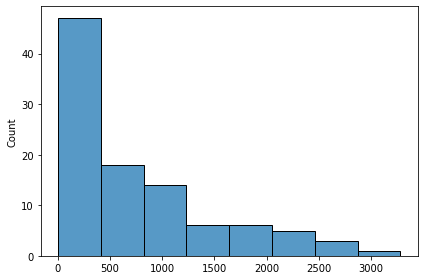

In [16]:
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
fig.patch.set_facecolor('xkcd:white')
sns.histplot(hist_rank)
plt.tight_layout()
plt.show()

# Appendix

## colloect feature set in 2 ways

In [ ]:
# blank feature set space
featureSet = np.float32([]).reshape(0,128)

all_des = np.empty(shape=[0, 128]) # DESDIM 128 차원 -> SIFT/ 32 -> ORB
    
for db_path in test_db_path_sorted[:5]:
    # print(db_path)
    des = sift_extractor(db_path)
    print(des.shape)
    
    # featureSet = np.append(featureSet, des, axis=1) #1차원 배열의 결합
    
    all_des = np.concatenate([all_des, des]) #모든 이미지의 des vector를 concat 해서 출력! #np.concat : 다차원 배열의 결합

In [33]:
featureSet.shape, all_des.shape

((1965, 128), (1965, 128))

# numpy 차원 추가

In [54]:
db_feat_set.reshape((1,)+db_feat_set.shape).shape

(1, 2651307, 128)

In [56]:
np.expand_dims(db_feat_set, axis=0).shape

(1, 2651307, 128)

In [59]:
db_feat_set[np.newaxis, :].shape #np.newaxis 가 말 그대로 새로운 축

(1, 2651307, 128)